# Load Data

In [160]:
# Libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn import tree
import graphviz

In [13]:
# Information about each user first transaction
fraud = pd.read_csv('.../fraud_data.csv')
fraud.head()

# fraud = pd.read_csv('/Users/jiaweiwang/Documents/xuexi/Python/sample_projects/mywork/04_identifying_fraudulent_activities/fraud_data.csv', 
#                     parse_dates=['signup_time', 'purchase_time'])

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [14]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
user_id           151112 non-null int64
signup_time       151112 non-null object
purchase_time     151112 non-null object
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [15]:
# Check unbalanced data
fraud.groupby('class')['class'].count()

class
0    136961
1     14151
Name: class, dtype: int64

In [16]:
# Mapping each numeric ip address to its country.
ip2country = pd.read_csv('.../IpAddress_to_Country.csv')
ip2country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [17]:
ip2country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
lower_bound_ip_address    138846 non-null float64
upper_bound_ip_address    138846 non-null int64
country                   138846 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


# Add country based on their IP address

In [18]:
country = []
for i in range(len(fraud)):
    ip_address = fraud.loc[i, 'ip_address']
    con = ip2country[(ip2country['lower_bound_ip_address'] <= ip_address) 
                     & (ip2country['upper_bound_ip_address'] >= ip_address)]
    if len(con) == 1:
        country.append(con['country'].values[0])
    else:
        country.append('Not Found')
        
fraud['country'] = country
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Not Found
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


# Feature Engineering

In [19]:
# Time difference between purchase and signup
fraud['time_diff'] = (pd.to_datetime(fraud['purchase_time']) - 
                      pd.to_datetime(fraud['signup_time'])).dt.total_seconds()

In [20]:
# Check for each device_id how many different users had it
device_id_count = fraud[['device_id', 'user_id']].groupby(['device_id'])['user_id'].count().reset_index()
device_id_count.rename(columns = {'user_id':'device_id_number'}, inplace = True)
df = fraud.merge(device_id_count, how = 'left', on = 'device_id')

# fraud['device_users'] = fraud.groupby('device_id').user_id.transform('nunique')

In [21]:
# Check for each ip_address how many different users had it
ip_count = fraud[['user_id', 'ip_address']].groupby(['user_id'])['ip_address'].count().reset_index()
ip_count.rename(columns = {'ip_address':'ip_count'}, inplace = True)
df = df.merge(ip_count, how = 'left', on = 'user_id')

# fraud['ip_users'] = fraud.groupby('ip_address').user_id.transform('nunique') 

In [22]:
# Signup day and week
df['signup_day_of_week'] = pd.to_datetime(df['signup_time']).apply(lambda x : x.dayofweek)
df['signup_week_of_year'] = pd.to_datetime(df['signup_time']).apply(lambda x : x.week)

# Purchase day and week
df['purchase_day_of_week'] = pd.to_datetime(df['purchase_time']).apply(lambda x : x.dayofweek)
df['purchase_week_of_year'] = pd.to_datetime(df['purchase_time']).apply(lambda x : x.week)
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_id_number,ip_count,signup_day_of_week,signup_week_of_year,purchase_day_of_week,purchase_week_of_year
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,1,1,1,9,5,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,1,1,6,23,0,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0,12,1,3,1,3,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Not Found,492085.0,1,1,1,18,0,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,1,1,1,30,2,37


# Machine Learning

**Preprocessing**

In [65]:
# Rename and define response variable, define explanatory variables
df.rename(columns = {'class':'is_fraud'}, inplace = True)
y = df['is_fraud']
X = df.drop(['user_id', 'signup_time', 'purchase_time', 'is_fraud', 'device_id'], axis = 1)

In [66]:
# Check if X contains missing value
X.isnull().sum()

purchase_value           0
source                   0
browser                  0
sex                      0
age                      0
ip_address               0
country                  0
time_diff                0
device_id_number         0
ip_count                 0
signup_day_of_week       0
signup_week_of_year      0
purchase_day_of_week     0
purchase_week_of_year    0
dtype: int64

In [67]:
# Categorical Features
X = pd.get_dummies(X, columns = ['source', 'browser', 'sex', 'country']).drop(['sex_F'], axis = 1)

**Spliting data into train and test dataset**

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101)

**Random Forest**

In [72]:
# Fit a Random Forest Classifier
rfc = RandomForestClassifier(n_estimators = 50, min_samples_leaf = 0.01)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.01, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [73]:
# Prefict off the y_test values
pred = rfc.predict(X_test)

In [76]:
# Create a classification report from the results
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     41222
           1       1.00      0.53      0.69      4112

   micro avg       0.96      0.96      0.96     45334
   macro avg       0.98      0.76      0.83     45334
weighted avg       0.96      0.96      0.95     45334



We are able to predict fraud with a precision of 96% and a recall of 53%.

In [77]:
# Show the Confusion Matrix for the predictions.
print(confusion_matrix(y_test, pred))

[[41222     0]
 [ 1940  2172]]


Note: For the sake of simplicity of this project, I am not optimizing hyperparameters of the random forest. If my goal was to get the absolute best performance out of the model, I would do a full cross-validated grid search to optimize. The hyperparameters that I would include in the grid search are:

- max depth of tree
- max features to consider at each split
- minimum number of sample required to be at a leaf node
- criterion (cost function, ie. entropy vs gini)
- number of trees (estimators) in forest

**ROC Curve**

In [81]:
# See how cutoff values will impact false positives and false negatives (as well as True Positive and True Negative)
y_score = rfc.predict_proba(X_test)[:,-1]
y_true = y_test
fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)
roc_auc = auc(fpr, tpr)

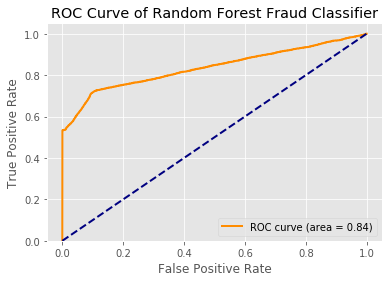

In [162]:
# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,1], [0,1], color = 'navy', lw = 2, linestyle = '--')

plt.xlim([-0.05, 1.05])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC Curve of Random Forest Fraud Classifier')
plt.legend(loc = 'lower right')

plt.show()

With no knowledge of the cost of false positives or false negatives the optimal points would be:

- For minimizing **false positive rate** - Pick the cut-off that corresponds to the point in the elbow region where FPR = 0, TPR = ~0.55.
- For maximizing **true positive rate** - decrease cut-off and choose a point along the line from ~(0.1,0.7) to (1,1)
In this case, we don't explicitly know the cost of false positives or false negatives, but we can make some reasonable assumptions. In our example:

- **False positive** means a customer is incorrectly flagged as a fraudulent user. This might not be so bad as long the classifier just triggers an additional verification step for users marked as positive by the model.
- **False negative** means a someone committing fraud will go undetected by the classifier. This is most likely a more serious error for the classifier to make.

- Given that **false negatives are assumed to be much more costly**, we should pick a point towards the upper right part of the ROC curve. More false alarms will be triggered, but virtually all fraudulent transactions will be caught.

**Feature Importance**

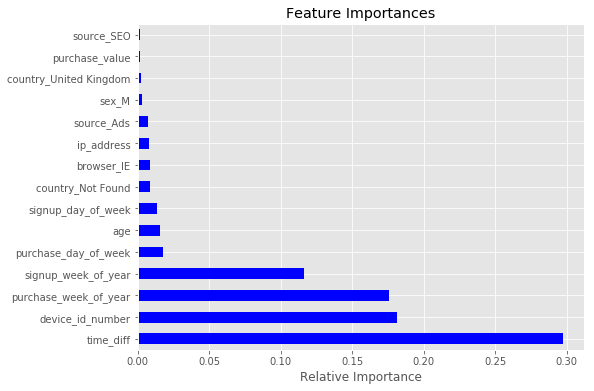

In [161]:
plt.figure(figsize = (8, 6))
feature_importance = pd.Series(rfc.feature_importances_, index = X.columns).sort_values(ascending = False).head(15)
feature_importance.plot(kind = 'barh', color = 'b')

# feature_importance.nlargest(15).plot('barh', color = 'b')
# feature_importance.plot.bar(color = 'b')  -- A Vertical bar plot instead of the horizontal one

plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
# ALTERNATIVE: Run below IF want to Display ALL features
features = X.columns
# features = X[X.columns.drop(list(X.filter(regex='country')))].columns  -- The way to REMOVE 'COUNTRY' variable
importances = rfc.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color = 'b', align = 'center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

The two takeaways are:

- A small time delta between signup and transaction is a really strong indicator of fraud
- A device used by multiple users is also a strong indicator of fraud

Lastly, I'll fit a simple decision tree to observe splits and visualize importance of features

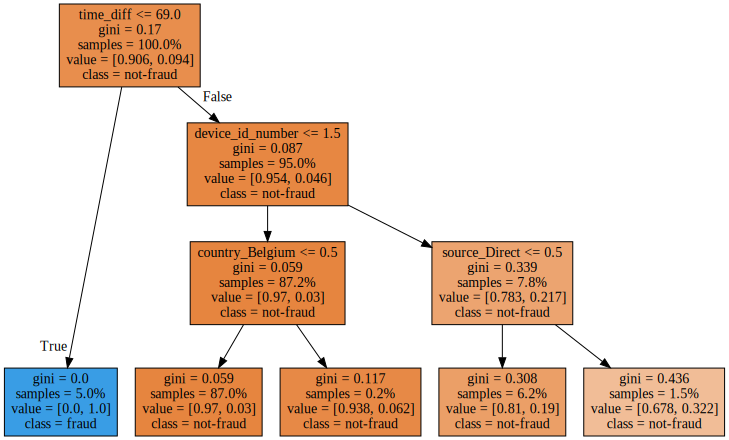

In [163]:
dt = tree.DecisionTreeClassifier(max_depth = 3)
dt.fit(X,y)
dot_data = tree.export_graphviz(dt, out_file = None, feature_names = X.columns, class_names = ['not-fraud', 'fraud'],
                     proportion = True, leaves_parallel = True, filled = True)
graphviz.Source(dot_data)

The decision tree again shows that "time delta" and number of device users are the strong features in our classifier.

# Building a Product from the ML Model

ML models are most useful when they can be integrated into a product to take advantage of the positives of the model while hiding the drawbacks. In this case, if I was to deploy this ML model to predict fraudulent transactions, I could look at the classifier's predicted probabilities -- PR(Y|X) -- to assess the risk of a user. In fact I could choose more than one threshold and route user to a certain experience as follows:

- **PR(Y|X) < Theshold1: Low-risk users**, normal experience; no special action needed. This will be the experience for most users.
- **Threshold1 <= PR(Y|X) <= Threshold2: Medium-risk users**, can prompt them for additional verification step or security question.
- **PR(Y|X) > Threshold2: High-risk users**, can freeze account until user calls in for verification or have someone manually reviewing cases like this.